tgb - 8/4/2019 - The goal of this notebook is to quantify the sensitivity of the MSE to the level chosen to calculate the residual of the conservation layers. There will be several steps:  
1) Generalizing the conservation layers  
2) Testing that the conservation layers still work (i.e. mass and energy are still conserved)  
3) Saving network at its "best performance"-epoch  
4) Inter-network comparison where different levels are chosen to calculate the residual

# 0) Initialization

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
#PREFIXDS = '8col009_ds1_'
PREFIXDS = PREFIX
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages

/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog
/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


In [2]:
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [3]:
scale_dict = load_pickle('./nn_config/scale_dicts/009_Wm2_scaling.pkl')
in_vars = load_pickle('./nn_config/scale_dicts/009_Wm2_in_vars.pkl')
out_vars = load_pickle('./nn_config/scale_dicts/009_Wm2_out_vars.pkl')
dP = load_pickle('./nn_config/scale_dicts/009_Wm2_dP.pkl')

train_gen = DataGenerator(
    data_fn = TRAINDIR+PREFIXDS+'train_shuffle.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+PREFIX+'norm.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)
valid_gen = DataGenerator(
    data_fn = TRAINDIR+PREFIX+'valid.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+PREFIX+'norm.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=False
)

# 1) Add residual-level choice for conservation layers

Adapt mass conservation layer

In [2]:
class MassConsLayer_choice(Layer):
    def __init__(self, inp_sub, inp_div, norm_q, hyai, hybi, lvl_choice, **kwargs):
        """
        Call using ([input, output])
        Assumes
        prior: [PHQ_nores, PHCLDLIQ, PHCLDICE, TPHYSTND_nores,
        QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        Returns
        post(erior): [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND_nores,
        QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        Added lvl_choice, a hyper-parameter to choose the level of mass conservation [0-29]
        """
        self.inp_sub, self.inp_div, self.norm_q, self.hyai, self.hybi = \
            np.array(inp_sub), np.array(inp_div), np.array(norm_q), np.array(hyai), np.array(hybi)
        self.lvl_choice = np.int32(lvl_choice)
        # Define variable indices here
        # Input
        self.PS_idx = 300
        self.LHFLX_idx = 303
        # Output
        self.PHQbef_idx = slice(0, self.lvl_choice) # Indices before the residual
        self.PHCLDLIQ_idx = slice(29, 59)
        self.PHCLDICE_idx = slice(59, 89)
        self.PRECT_idx = 212
        self.PRECTEND_idx = 213

        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)

    def get_config(self):
        config = {'inp_sub': list(self.inp_sub), 'inp_div': list(self.inp_div),
                  'norm_q': list(self.norm_q), 'hyai': list(self.hyai),
                  'hybi': list(self.hybi), 'lvl_choice':self.lvl_choice}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, arrs):
        inp, prior = arrs

        # 1. Compute dP_tilde
        dP_tilde = compute_dP_tilde(
            inp[:, self.PS_idx],
            self.inp_div[self.PS_idx], self.inp_sub[self.PS_idx],
            self.norm_q, self.hyai, self.hybi
        )

        # 2. Compute vertical cloud water integral
        CLDINT = K.sum(dP_tilde *
                       (prior[:, self.PHCLDLIQ_idx] + prior[:, self.PHCLDICE_idx]),
                       axis=1)

        # 3. Compute water vapor integral minus the water vapor residual
        # Careful with handling the pressure vector since it is not aligned
        # with the prior water vapor vector
        VAPINT = K.sum(dP_tilde[:, self.PHQbef_idx] * prior[:, self.PHQbef_idx], 1) +\
        K.sum(dP_tilde[:, self.lvl_choice+1:30] * prior[:, self.lvl_choice:29], 1)

        # 4. Compute forcing (see Tom's note for details, I am just copying)
        LHFLX = (inp[:, self.LHFLX_idx] * self.inp_div[self.LHFLX_idx] +
                 self.inp_sub[self.LHFLX_idx])
        PREC = prior[:, self.PRECT_idx] + prior[:, self.PRECTEND_idx]

        # 5. Compute water vapor tendency at level lvl_choice as residual
        PHQ_LVL = (LHFLX - PREC - CLDINT - VAPINT) / dP_tilde[:, self.lvl_choice]

        # 6. Concatenate output vector
        post = tf.concat([
            prior[:, self.PHQbef_idx], PHQ_LVL[:, None],
            prior[:, self.lvl_choice:]
        ], axis=1)
        return post

    def compute_output_shape(self, input_shape):
        """Input shape + 1"""
        return (input_shape[0][0], input_shape[0][1] + 1)

Adapt enthalpy conservation layer

In [3]:
class EntConsLayer_choice(Layer):
    def __init__(self, inp_sub, inp_div, norm_q, hyai, hybi, lvl_choice, **kwargs):
        """
        Call using ([input, output])
        Assumes
        prior: [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND_nores,
        QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        Returns
        post(erior): [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND,
        QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        """
        self.inp_sub, self.inp_div, self.norm_q, self.hyai, self.hybi = \
            np.array(inp_sub), np.array(inp_div), np.array(norm_q), np.array(hyai), np.array(hybi)
        self.lvl_choice = np.int32(lvl_choice)
        # Define variable indices here
        # Input
        self.PS_idx = 300
        self.SHFLX_idx = 302
        self.LHFLX_idx = 303

        # Output
        self.PHQ_idx = slice(0, 30)
        self.PHCLDLIQ_idx = slice(30, 60)
        self.Tbef_idx = slice(90, 90+self.lvl_choice)
        self.DTVKE_idx = slice(179, 209)
        self.FSNT_idx = 209
        self.FSNS_idx = 210
        self.FLNT_idx = 211
        self.FLNS_idx = 212
        self.PRECT_idx = 213
        self.PRECTEND_idx = 214
        self.PRECST_idx = 215
        self.PRECSTEND_idx = 216

        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)

    def get_config(self):
        config = {'inp_sub': list(self.inp_sub), 'inp_div': list(self.inp_div),
                  'norm_q': list(self.norm_q), 'hyai': list(self.hyai),
                  'hybi': list(self.hybi), 'lvl_choice': self.lvl_choice}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, arrs):
        inp, prior = arrs

        # 1. Compute dP_tilde
        dP_tilde = compute_dP_tilde(
            inp[:, self.PS_idx],
            self.inp_div[self.PS_idx], self.inp_sub[self.PS_idx],
            self.norm_q, self.hyai, self.hybi
        )

        # 2. Compute net energy input from phase change and precipitation
        PHAS = L_I / L_V * (
                (prior[:, self.PRECST_idx] + prior[:, self.PRECSTEND_idx]) -
                (prior[:, self.PRECT_idx] + prior[:, self.PRECTEND_idx])
        )

        # 3. Compute net energy input from radiation, SHFLX and TKE
        RAD = (prior[:, self.FSNT_idx] - prior[:, self.FSNS_idx] -
               prior[:, self.FLNT_idx] + prior[:, self.FLNS_idx])
        SHFLX = (inp[:, self.SHFLX_idx] * self.inp_div[self.SHFLX_idx] +
                 self.inp_sub[self.SHFLX_idx])
        KEDINT = K.sum(dP_tilde * prior[:, self.DTVKE_idx], 1)

        # 4. Compute tendency of vapor due to phase change
        LHFLX = (inp[:, self.LHFLX_idx] * self.inp_div[self.LHFLX_idx] +
                 self.inp_sub[self.LHFLX_idx])
        VAPINT = K.sum(dP_tilde * prior[:, self.PHQ_idx], 1)
        SPDQINT = (VAPINT - LHFLX) * L_S / L_V

        # 5. Same for cloud liquid water tendency
        SPDQCINT = K.sum(dP_tilde * prior[:, self.PHCLDLIQ_idx], 1) * L_I / L_V

        # 6. And the same for T but remember residual is still missing
        DTINT = K.sum(dP_tilde[:, :self.lvl_choice] *\
                      prior[:, self.Tbef_idx], 1) +\
        K.sum(dP_tilde[:, self.lvl_choice+1:30] *\
             prior[:, 90+self.lvl_choice:119], 1)

        # 7. Compute DT30 as residual
        DT_LVL = (
                       PHAS + RAD + SHFLX + KEDINT - SPDQINT - SPDQCINT - DTINT
               ) / dP_tilde[:, self.lvl_choice]

        # 8. Concatenate output vector
        post = tf.concat([
            prior[:, :(90+self.lvl_choice)], DT_LVL[:, None], \
            prior[:, (90+self.lvl_choice):]
        ], axis=1)
        return post

    def compute_output_shape(self, input_shape):
        """Input shape + 1"""
        return (input_shape[0][0], input_shape[0][1] + 1)

Conserving network with choice of residual layer

In [39]:
# Define levels to calculate as residuals
mlev = 29
elev = 29

In [40]:
inpC = Input(shape=(304,))
densout = Dense(512, activation='linear')(inpC)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(214, activation='linear')(densout)
densout = LeakyReLU(alpha=0.3)(densout)
surfout = SurRadLayer(
    inp_div=train_gen.input_transform.div,
    inp_sub=train_gen.input_transform.sub,
    norm_q=scale_dict['PHQ'],
    hyai=hyai, hybi=hybi
)([inpC, densout])
massout = MassConsLayer_choice(
    inp_div=train_gen.input_transform.div,
    inp_sub=train_gen.input_transform.sub,
    norm_q=scale_dict['PHQ'],
    hyai=hyai, hybi=hybi\
    , lvl_choice=mlev
)([inpC, surfout])
enthout = EntConsLayer_choice(
    inp_div=train_gen.input_transform.div,
    inp_sub=train_gen.input_transform.sub,
    norm_q=scale_dict['PHQ'],
    hyai=hyai, hybi=hybi\
    , lvl_choice=elev
)([inpC, massout])
C_1515 = tf.keras.models.Model(inpC, enthout)

In [41]:
C_1515.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 304)]        0                                            
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 512)          156160      input_6[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_30 (LeakyReLU)      (None, 512)          0           dense_30[0][0]                   
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 512)          262656      leaky_re_lu_30[0][0]             
____________________________________________________________________________________________

Define different losses to track conservation of radiation, mass and enthalpy

In [42]:
RadLoss = WeakLoss(inpC, inp_div=train_gen.input_transform.div,
                   inp_sub=train_gen.input_transform.sub,
                   norm_q=scale_dict['PHQ'],
                   hyai=hyai, hybi=hybi, name='radloss',
                   alpha_mass=0, alpha_ent=0,
                   alpha_lw=0.5, alpha_sw=0.5)
MasLoss = WeakLoss(inpC, inp_div=train_gen.input_transform.div,
                   inp_sub=train_gen.input_transform.sub,
                   norm_q=scale_dict['PHQ'],
                   hyai=hyai, hybi=hybi, name='masloss',
                   alpha_mass=1, alpha_ent=0,
                   alpha_lw=0, alpha_sw=0)
EntLoss = WeakLoss(inpC, inp_div=train_gen.input_transform.div,
                   inp_sub=train_gen.input_transform.sub,
                   norm_q=scale_dict['PHQ'],
                   hyai=hyai, hybi=hybi, name='entloss',
                   alpha_mass=0, alpha_ent=1,
                   alpha_lw=0, alpha_sw=0)

Callbacks  
Keras documentation at https://keras.io/callbacks/#modelcheckpoint  
Nice example at https://www.kaggle.com/cbryant/keras-cnn-with-pseudolabeling-0-1514-lb/

In [43]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('HDF_DATA/Cm{mlev}_e{elev}.hdf5'.format(
    mlev = mlev, elev = elev),
                           save_best_only=True, monitor='val_loss', mode='min')

In [44]:
C_1515.compile(tf.keras.optimizers.RMSprop(), loss=mse, metrics=[RadLoss,MasLoss,EntLoss])

In [46]:
# Nep = 5
# C_1515.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
#               callbacks=[earlyStopping, mcp_save])

# 2) Build inter-network comparison

In [35]:
def Conserving_Model(maslevel,entlevel):
    inpC = Input(shape=(304,))
    densout = Dense(512, activation='linear')(inpC)
    densout = LeakyReLU(alpha=0.3)(densout)
    for i in range (4):
        densout = Dense(512, activation='linear')(densout)
        densout = LeakyReLU(alpha=0.3)(densout)
    densout = Dense(214, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
    surfout = SurRadLayer(
        inp_div=train_gen.input_transform.div,
        inp_sub=train_gen.input_transform.sub,
        norm_q=scale_dict['PHQ'],
        hyai=hyai, hybi=hybi
    )([inpC, densout])
    massout = MassConsLayer_choice(
        inp_div=train_gen.input_transform.div,
        inp_sub=train_gen.input_transform.sub,
        norm_q=scale_dict['PHQ'],
        hyai=hyai, hybi=hybi\
        , lvl_choice=maslevel
    )([inpC, surfout])
    enthout = EntConsLayer_choice(
        inp_div=train_gen.input_transform.div,
        inp_sub=train_gen.input_transform.sub,
        norm_q=scale_dict['PHQ'],
        hyai=hyai, hybi=hybi\
        , lvl_choice=entlevel
    )([inpC, massout])
    return tf.keras.models.Model(inpC, enthout)

Train 5 different models for now:  
residual level (0,0); residual level (14,14); residual level (29,29); residual level (0,29); residual level (29,0)

In [47]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

In [55]:
Nep = 20
masresid = [0,14,29,0,29]
entresid = [0,14,29,29,0]

NN = {}
for i,imres in enumerate(masresid):
    ieres = entresid[i]; # Enthalpy residual index
    print('Mas index=',str(imres),' & Ent index=',str(ieres))
    graph = tf.Graph()
    with tf.Session(graph=graph):

        # 1) Create model
        # Unconstrained model with 5 dense layers (Notebook 009)
        NN = Conserving_Model(imres,ieres)
        print('NN is ',NN.summary())

        # 2) Compile model
        NN.compile(tf.keras.optimizers.RMSprop(), loss=mse)

        # 3) Train and save model
        path = TRAINDIR+'HDF5_DATA/Cm{mlev}_e{elev}.hdf5'.format(
            mlev = imres, elev = ieres) # Path where model is saved
        mcp_save = ModelCheckpoint(path,save_best_only=True,\
                                   monitor='val_loss', mode='min')
        NN.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
                        callbacks=[earlyStopping, mcp_save])
        print('NN saved in ',path)

Mas index= 0  & Ent index= 0
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 304)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          156160      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 512)          0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      leaky_re_lu[0][0]                
_________________________________________________________________

41376/41376 [==============================] - 621s 15ms/step - loss: 221.4665 - val_loss: 182.5148
Epoch 2/20
41376/41376 [==============================] - 624s 15ms/step - loss: 180.0365 - val_loss: 175.3354
Epoch 3/20
41376/41376 [==============================] - 625s 15ms/step - loss: 173.8087 - val_loss: 172.8146
Epoch 4/20
41376/41376 [==============================] - 621s 15ms/step - loss: 170.5986 - val_loss: 171.3948
Epoch 5/20
41376/41376 [==============================] - 622s 15ms/step - loss: 168.5045 - val_loss: 172.9449
Epoch 6/20
41376/41376 [==============================] - 622s 15ms/step - loss: 167.0215 - val_loss: 165.0058
Epoch 7/20
41376/41376 [==============================] - 624s 15ms/step - loss: 165.7980 - val_loss: 170.0925
Epoch 8/20
41376/41376 [==============================] - 621s 15ms/step - loss: 164.8660 - val_loss: 165.8460
Epoch 9/20
41376/41376 [==============================] - 622s 15ms/step - loss: 164.0545 - val_loss: 163.8327
Epoch 10/20


Exception ignored in: <function BaseSession._Callable.__del__ at 0x153ac1faa1e0>
Traceback (most recent call last):
  File "/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')
Exception ignored in: <function BaseSession._Callable.__del__ at 0x153ac1faa1e0>
Traceback (most recent call last):
  File "/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')
Exception ignored in: <function BaseSession._Callable.__del__ at 0x153ac1faa1e0>
Traceback (most recent call last):
  File "/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1473, in _

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 304)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          156160      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 512)          0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      leaky_re_lu[0][0]                
______________________________________________________________________________________________

41376/41376 [==============================] - 615s 15ms/step - loss: 220.9484 - val_loss: 186.2884
Epoch 2/20
41376/41376 [==============================] - 615s 15ms/step - loss: 179.8753 - val_loss: 185.0330
Epoch 3/20
41376/41376 [==============================] - 614s 15ms/step - loss: 173.6129 - val_loss: 171.4436
Epoch 4/20
41376/41376 [==============================] - 615s 15ms/step - loss: 170.3102 - val_loss: 166.9218
Epoch 5/20
41376/41376 [==============================] - 613s 15ms/step - loss: 168.3159 - val_loss: 168.4088
Epoch 6/20
41376/41376 [==============================] - 616s 15ms/step - loss: 166.7236 - val_loss: 179.2872
Epoch 7/20
41376/41376 [==============================] - 616s 15ms/step - loss: 165.4986 - val_loss: 168.4477
Epoch 8/20
41376/41376 [==============================] - 614s 15ms/step - loss: 164.5028 - val_loss: 170.1812
Epoch 9/20
41376/41376 [==============================] - 614s 15ms/step - loss: 163.8114 - val_loss: 165.1545
Epoch 10/20


# 3) Read networks for statistics on +0K,+4K

tgb - 8/10/2019 - Do not create generators simultaneously using the data file

Loading model
j= 0
Loading statistics
Error Cm0_e0 /local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc = 1.58e+02 +- 9.82e+02
j= 1
Loading statistics


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


Error Cm0_e0 /local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc = 3.82e+02 +- 3.23e+03
Loading model
j= 0
Loading statistics
Error Cm14_e14 /local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc = 1.58e+02 +- 9.92e+02
j= 1
Loading statistics


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


Error Cm14_e14 /local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc = 4.40e+02 +- 6.17e+03
Loading model
j= 0
Loading statistics
Error Cm29_e29 /local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc = 1.58e+02 +- 9.93e+02
j= 1
Loading statistics


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


Error Cm29_e29 /local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc = 4.77e+02 +- 4.58e+03
Loading model
j= 0
Loading statistics
Error Cm0_e29 /local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc = 1.56e+02 +- 9.78e+02
j= 1
Loading statistics


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


Error Cm0_e29 /local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc = 4.84e+02 +- 7.45e+03
Loading model
j= 0
Loading statistics
Error Cm29_e0 /local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc = 1.57e+02 +- 9.79e+02
j= 1
Loading statistics


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


Error Cm29_e0 /local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc = 4.97e+02 +- 6.78e+03


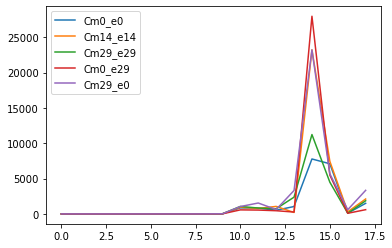

In [18]:
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,\
           'weak_loss_0':mse,'weak_loss_1':mse,'MassConsLayer_choice':MassConsLayer_choice,\
           'EntConsLayer_choice':EntConsLayer_choice}
data_fn_array = ['/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc','/local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc']
dataref = ['','4K']
NNa = ['Cm0_e0','Cm14_e14','Cm29_e29','Cm0_e29','Cm29_e0']
    
for i,NNs in enumerate(NNa):
    NN = {}
    print('Loading model') # 1) Load model
    NN = load_model(TRAINDIR+'HDF5_DATA/'+NNs+'.hdf5',custom_objects=dict_lay)    
    for j,data_fn in enumerate(data_fn_array):
        md = {}
        print('j=',j)
        print('Loading statistics') # 2) Define model diagnostics object
        md = ModelDiagnostics(NN,config_fn,data_fn)
        # 3) Calculate statistics and save in pickle file
        md.stats = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNs+
                                   'md'+dataref[j]+'.pkl','rb'))
        print('Error',NNs,data_fn,'=','%.2e'%md.mse_W2m4().mean((0,1,2)),\
         '+-','%.2e'%md.mse_W2m4().std((0,1,2)))
        if j==1: plt.plot(md.mse_W2m4().mean(axis=(0,1))[200:],label=NNs)
            
plt.legend()

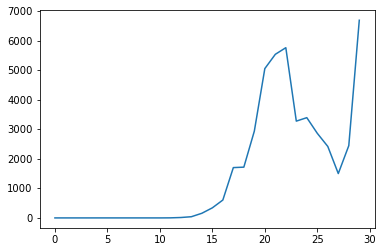

In [12]:
plt.plot(md.mse_W2m4().mean(axis=(0,1))[0:30])

# 4) Repeat and better separate statistics training, validation and test set

tgb - 1/6/2020 - Better separate training, validation and test sets for PRL revisions

In [2]:
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,\
           'weak_loss_0':mse,'weak_loss_1':mse,'MassConsLayer_choice':MassConsLayer_choice,\
           'EntConsLayer_choice':EntConsLayer_choice}
data_fn_array = ['/local/Tom.Beucler/SPCAM_PHYS/8col009_01_train.nc',
                 '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc',
                 '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_test.nc']
dataref = ['train','valid','test']
NNa = ['Cm0_e0','Cm14_e14','Cm29_e29','Cm0_e29','Cm29_e0']
    
for i,NNs in enumerate(NNa):
    NN = {}
    print('Loading model') # 1) Load model
    NN = load_model(TRAINDIR+'HDF5_DATA/'+NNs+'.hdf5',custom_objects=dict_lay)    
    for j,data_fn in enumerate(data_fn_array):
        md = {}
        print('j=',j)
        print('Loading statistics') # 2) Define model diagnostics object
        md = ModelDiagnostics(NN,config_fn,data_fn)
        # 3) Calculate statistics and save in pickle file
        md.stats = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNs+
                                   'md'+dataref[j]+'.pkl','rb'))
        print('Error',NNs,data_fn,'=','%.2e'%md.mse_W2m4().mean((0,1,2)),\
         '+-','%.2e'%md.mse_W2m4().std((0,1,2)))
        if j==1: plt.plot(md.mse_W2m4().mean(axis=(0,1))[200:],label=NNs)
            
plt.legend()

W0107 06:38:43.145369 22785270019904 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0107 06:38:43.150576 22785270019904 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0107 06:38:43.176507 22785270019904 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros

Loading model
j= 0
Loading statistics


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


FileNotFoundError: [Errno 2] No such file or directory: '/local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA/Cm0_e0mdtrain.pkl'